### Comparing Homebrew_CTD, a Seabird CTD, an RBR CTD, and a YSI Castaway CTD
One station, taken following recovery of ru23 off the coast of NJ
- Date: 2024.4.22
- Location (approx): 39-23.199N  074-04.757W 

The homebrew CTD *really* needs a lot of time at the surface to let the temperature sensor be accurate (at least a few minutes...). After all this testing, I think this sensor should be used: https://bluerobotics.com/store/sensors-cameras/sensors/celsius-sensor-r1/

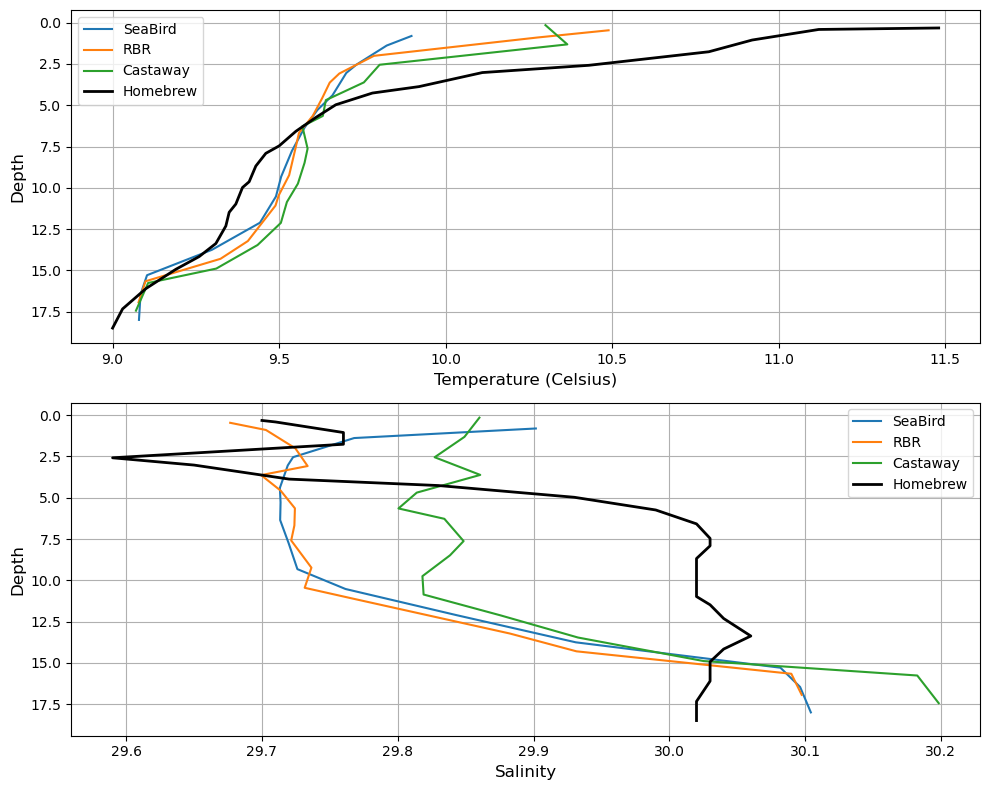

In [1]:
import pandas as pd             # data processing
import matplotlib.pyplot as plt # plotting
import gsw                      # data conversion 

# FILES
homebrew_file    = 'Homebrew_CTD_DATAFILE.txt'
seabird_file     = 'SeaBird_RU23_Recovery.cnv'
rbr_file         = 'RBR_204546_20240424_1333_data.txt'
castaway_file    = 'Castaway_11D101493_20240422_171552_raw.csv'

homebrew_names   = ['ec','tds','psu','mbar','c','m']
seabird_names    = ['m', 'psu', 'c', 'bad']
rbr_names        = ['time','mS/cm','c','dbar1','dbar2','m','psu','m/s','uS/cm','kg/m3']
castaway_names   = ['Time (Seconds)','Pressure (Decibar)','Temperature (Celsius)','Conductivity (MicroSiemens per Centimeter)']
# castaway_names_processed   = ['Pressure (Decibar)', 'Depth (Meter)', 'Temperature (Celsius)', 
                    # 'Conductivity (MicroSiemens per Centimeter)', 'Specific conductance (MicroSiemens per Centimeter)', 
                    # 'Salinity (Practical Salinity Scale)', 'Sound velocity (Meters per Second)', 'Density (Kilograms per Cubic Meter)']

# PROCESS THE FILES
homebrew    = pd.read_csv(homebrew_file,sep=',',names=homebrew_names)
seabird     = pd.read_csv(seabird_file,sep='\s+',skiprows=114,names=seabird_names)
rbr         = pd.read_csv(rbr_file,sep=',',skiprows=1,names=rbr_names)
castaway    = pd.read_csv(castaway_file,sep=',',skiprows=30,names=castaway_names)

# CALCULATE PSU USING GSW
homebrew['ec_numeric']  = pd.to_numeric(homebrew['ec'], errors='coerce')
homebrew['mS/cm']       = (homebrew['ec_numeric'] / 1000)
homebrew['dbar']        = homebrew['mbar'] / 10    
homebrew['psu_calc']    = gsw.SP_from_C(homebrew['mS/cm'], homebrew['c'], homebrew['dbar'])

rbr['psu_calc']         = gsw.SP_from_C(rbr['mS/cm'],rbr['c'],rbr['dbar1'])

castaway['mS/cm']       = castaway['Conductivity (MicroSiemens per Centimeter)'] / 1000
castaway['psu_calc']    = gsw.SP_from_C(castaway['mS/cm'], castaway['Temperature (Celsius)'], castaway['Pressure (Decibar)'])

# PRIOR OFFSET VALUES FOR HOMEBREW
SAL_CAL = 10.6 #1.35 # last time was 1.35
homebrew['psu_off'] = homebrew['psu'] + SAL_CAL

TEMP_CAL = -0.4 # last time was 0.2
homebrew['c_off'] = homebrew['c'] + TEMP_CAL

# PLOTS TO LOCATE DOWNCASTS 
# homebrew['m'][70:319].plot()
# seabird['m'][55:130].plot()
# rbr['m'][160:1061].plot()
# castaway['Pressure (Decibar)'][210:690].plot()

# LOCATE DOWNCASTS
homebrew = homebrew.iloc[70:319]    
seabird  = seabird.iloc[55:130]     
rbr      = rbr.iloc[160:1061]       
castaway = castaway.iloc[210:690]   

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# First subplot: Temperature and Depth
ax[0].plot(seabird['c'][::5], seabird['m'][::5], label='SeaBird')
ax[0].plot(rbr['c'][::60], rbr['m'][::60], label='RBR')
ax[0].plot(castaway['Temperature (Celsius)'][::30], castaway['Pressure (Decibar)'][::30], label='Castaway')
ax[0].plot(homebrew['c_off'][::10], homebrew['m'][::10], c='black',linewidth=2,label='Homebrew')
ax[0].set_xlabel('Temperature (Celsius)',fontsize=12)
ax[0].set_ylabel('Depth',fontsize=12)
# ax[0].set_title('Temperature vs Depth')
ax[0].invert_yaxis()
ax[0].legend()
ax[0].grid()

# Second subplot: Salinity and Depth
ax[1].plot(seabird['psu'][::5], seabird['m'][::5], label='SeaBird')
ax[1].plot(rbr['psu'][::60], rbr['m'][::60], label='RBR')
ax[1].plot(castaway['psu_calc'][::30], castaway['Pressure (Decibar)'][::30], label='Castaway')
ax[1].plot(homebrew['psu_off'][::10], homebrew['m'][::10], c='black',linewidth=2,label='Homebrew')
ax[1].set_xlabel('Salinity',fontsize=12)
ax[1].set_ylabel('Depth',fontsize=12)
# ax[1].set_title('Salinity'fontsize=14)
ax[1].invert_yaxis()
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.savefig('2024_4_22_quad_comparison.png')

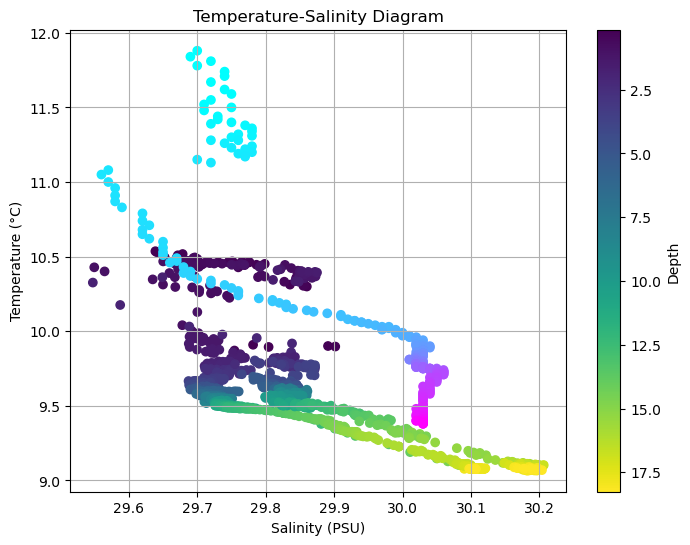

In [3]:
# PLOT TS DIAGRAM
plt.figure(figsize=(8, 6))

# Plot temperature vs salinity for each dataset, colored by depth
seabird_scatter = plt.scatter(seabird['psu'], seabird['c'], c=seabird['m'], cmap='viridis')
rbr_scatter = plt.scatter(rbr['psu'], rbr['c'], c=rbr['m'], cmap='viridis')
castaway_scatter = plt.scatter(castaway['psu_calc'], castaway['Temperature (Celsius)'], c=castaway['Pressure (Decibar)'], cmap='viridis')
homebrew_scatter = plt.scatter(homebrew['psu_off'],homebrew['c'], c=homebrew['m'], cmap='cool')

plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature-Salinity Diagram')

# colorbar with reversed colors
cbar = plt.colorbar(castaway_scatter, label='Depth', orientation='vertical')
cbar.ax.invert_yaxis()

plt.grid()
plt.savefig('ts_plot.png')
